## 1D Linear operator with one parameter


This chapter introduces a basic example of the framework developed in Chapter 3. We take a one-dimensional system with a single parameter and extract an operator out of it.


\begin{align*}
\mathcal{L}_x^\phi u(x) &= f(x) \\
\mathcal{L}_x^\phi &:= \phi \cdot + \frac{d}{dx}\cdot
\end{align*}

It is trivial to verify linearity of the operator:

\begin{align*}
u, f : [0, 2\pi] &\rightarrow \mathbb{K}, \alpha, \beta \in \mathbb{R} \\
\mathcal{L}_x^\phi (\alpha u + \beta f) &= \phi (\alpha u + \beta f) + \frac{d}{dx}(\alpha u + \beta f) \\
&= \alpha \phi u + \beta \phi f + \alpha \frac{d}{dx}u + \beta \frac{d}{dx}f \\
&= \alpha \mathcal{L}_x^\phi u + \beta \mathcal{L}_x^\phi f
\end{align*}

One of the solutions to this system might be:

\begin{align*}
u(x) &= x^3 \\
f(x) &= \phi x^3 + 3x^2 \\
x &\in [0, 1]
\end{align*}

We define Gaussian priors on the input and output:

\begin{align*}
u(x) &\sim \mathcal{GP}(0, k_{uu}(x,x',\theta)) \\
f(x) &\sim \mathcal{GP}(0, k_{ff}(x,x',\theta,\phi))
\end{align*}

A noisy data model for the above system can be defined as:

\begin{align*}
y_u &= u(X_u) + \epsilon_u; \epsilon_u \sim \mathcal{N}(0, \sigma_u^2I)\\
y_f &= f(X_f) + \epsilon_f; \epsilon_f \sim \mathcal{N}(0, \sigma_f^2I)
\end{align*}

For the sake of simplicity, we ignore the noise terms $\epsilon_u$ and $\epsilon_f$ while simulating the data. They're nevertheless beneficial, when computing the negative log marginal likelihood (NLML) so that the resulting covariance matrix is mostly more well-behaved for reasons as they were outlined in the **!!!preface(if it's in the paper!)**.


For the parameter estimation problem for the linear operator described above, we are given $\{X_u, y_u\}$, $\{X_f, y_f\}$ and we need to estimate $\phi$.


**Remark** : A number of code cells from the notebook are missing in the report. This has been done to improve readability. For the complete notebook, please check the github repository.


#### Step 1: Simulate data


We use $\phi = 2$.


In [1]:
import numpy as np
import sympy as sp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import time

In [2]:
def get_simulated_data(n1, n2, phi):
    x_u = np.random.rand(n1)
    y_u = np.power(x_u, 3)
    x_f = np.random.rand(n2)
    y_f = phi*np.power(x_f, 3) + 3*np.power(x_f,2)
    return(x_u, y_u, x_f, y_f)

In [3]:
(x_u, y_u, x_f, y_f) = get_simulated_data(10, 7, 2)
f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(10,3))
f.suptitle("Input and Output for the operator")
ax1.plot(x_u, y_u, 'o')
ax1.set(xlabel= "x", ylabel= "u(x)")
ax2.plot(x_f, y_f, 'ro')
ax2.set(xlabel= "x", ylabel= "f(x)")

[<matplotlib.text.Text at 0x1104fb048>, <matplotlib.text.Text at 0x1104e6940>]

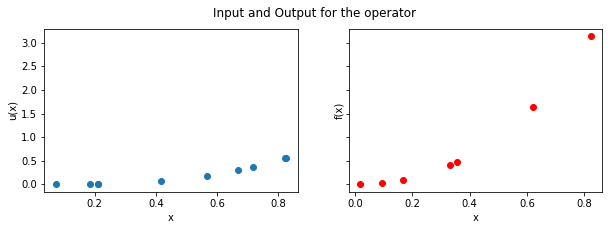

In [4]:
plt.show()

#### Step 2: Evaluate kernels


We use the RBF kernel defined as:

\begin{align*}
k_{uu}(x_i, x_j; \theta) = \theta exp(-\frac{1}{2l}(x_i-x_j)^2)
\end{align*}

throughout the report. It is worth noting that this step uses information about $\mathcal{L}_x^\phi$ but not about $u(x)$ or $f(x)$. The derivatives are computed using *sympy*.

In [5]:
x_i, x_j, theta, l, phi = sp.symbols('x_i x_j theta l phi')
kuu_sym = theta*sp.exp(-l*((x_i - x_j)**2))
kuu_fn = sp.lambdify((x_i, x_j, theta, l), kuu_sym, "numpy")
def kuu(x, theta, l):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kuu_fn(x[i], x[j], theta, l)
    return k

\begin{align*}
k_{ff}(x_i,x_j;\theta,\phi) &= \mathcal{L}_{x_i}^\phi \mathcal{L}_{x_j}^\phi k_{uu}(x_i, x_j; \theta) \\
&= \mathcal{L}_{x_i}^\phi \left( \phi k_{uu} + \frac{\partial}{\partial x_j}k_{uu} \right) \\
&= \phi^2 k_{uu} + \phi \frac{\partial}{\partial x_j}k_{uu} + \phi \frac{\partial}{\partial x_i}k_{uu} + \frac{\partial}{\partial x_i}\frac{\partial}{\partial x_j}k_{uu} \\
&= \theta exp(-\frac{1}{2l}(x_i-x_j)^2)\left[ \phi^2 + 2\phi |x_i-x_j| + (x_i-x_j)^2 + 1 \right]
\end{align*}

In [6]:
kff_sym = phi**2*kuu_sym \
            + phi*sp.diff(kuu_sym, x_j) \
            + phi*sp.diff(kuu_sym, x_i) \
            + sp.diff(kuu_sym, x_j, x_i)
kff_fn = sp.lambdify((x_i, x_j, theta, l, phi), kff_sym, "numpy")
def kff(x, theta, l, phi):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kff_fn(x[i], x[j], theta, l, phi)
    return k

\begin{align*}
k_{fu}(x_i,x_j;\theta,\phi) &= \mathcal{L}_{x_i}^\phi k_{uu}(x_i, x_j; \theta) \\
&= \phi k_{uu} + \frac{\partial}{\partial x_i}k_{uu}  \\
&= \theta exp(-\frac{1}{2l}(x_i-x_j)^2) \left[ (\frac{1}{2})2|x_i-x_j| + \phi \right] \\
&= \theta exp(-\frac{1}{2l}(x_i-x_j)^2)(\phi + |x_i-x_j|)
\end{align*}

In [7]:
kfu_sym = phi*kuu_sym + sp.diff(kuu_sym, x_i)
kfu_fn = sp.lambdify((x_i, x_j, theta, l, phi), kfu_sym, "numpy")
def kfu(x1, x2, theta, l, phi):
    k = np.zeros((x2.size, x1.size))
    for i in range(x2.size):
        for j in range(x1.size):
            k[i,j] = kfu_fn(x2[i], x1[j], theta, l, phi)
    return k

\begin{align*}
k_{uf}(x_i,x_j;\theta,\phi) &= \mathcal{L}_{x_j}^\phi k_{uu}(x_i, x_j; \theta) \\
&= \phi k_{uu} + \frac{\partial}{\partial x_j}k_{uu}  \\
&= \theta exp(-\frac{1}{2l}(x_i-x_j)^2) \left[ (\frac{1}{2})2|x_i-x_j| + \phi \right]\\
&= \theta exp(-\frac{1}{2l}(x_i-x_j)^2)(\phi+|x_i-x_j|)
\end{align*}

In [8]:
def kuf(x1, x2, theta, l, phi):
    return kfu(x1, x2, theta, l, phi).T

#### Step 3: Compute the negative log marginal likelihood(NLML)

The following covariance matrix is the result of our discussion at the end of Chapter 1.3.1, with an added noise parameter:

\begin{align*}
K = \begin{bmatrix}
k_{uu}(X_u, X_u; \theta) + \sigma_u^2I & k_{uf}(X_u, X_f; \theta, \phi) \\
k_{fu}(X_f, X_u; \theta, \phi) & k_{ff}(X_f, X_f; \theta, \phi) + \sigma_f^2I
\end{bmatrix}
\end{align*}

For simplicity, assume $\sigma_u = \sigma_f$.

\begin{align*}
\mathcal{NLML} = \frac{1}{2} \left[ log|K| + y^TK^{-1}y + Nlog(2\pi) \right]
\end{align*}

where $y = \begin{bmatrix}
y_u \\
y_f
\end{bmatrix}$.

In [9]:
def nlml(params, x1, x2, y1, y2, s):
    params = np.exp(params)
    K = np.block([
        [
            kuu(x1, params[0], params[1]) + s*np.identity(x1.size),
            kuf(x1, x2, params[0], params[1], params[2])
        ],
        [
            kfu(x1, x2, params[0], params[1], params[2]),
            kff(x2, params[0], params[1], params[2]) + s*np.identity(x2.size)
        ]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) \
               + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

#### Step 4: Optimize hyperparameters


In [10]:
nlml_wp = lambda params: nlml(params, x_u, x_f, y_u, y_f, 1e-6)
m = minimize(nlml_wp, np.random.rand(3), method="Nelder-Mead")

In [11]:
m

 final_simplex: (array([[ 2.47686625, -0.7450802 ,  0.69374954],
       [ 2.47693005, -0.74510427,  0.69374962],
       [ 2.47692091, -0.74510869,  0.69374958],
       [ 2.47688263, -0.74508511,  0.69374952]]), array([-74.87118536, -74.87118536, -74.87118535, -74.87118535]))
           fun: -74.87118535724949
       message: 'Optimization terminated successfully.'
          nfev: 321
           nit: 174
        status: 0
       success: True
             x: array([ 2.47686625, -0.7450802 ,  0.69374954])

In [12]:
np.exp(m.x)

array([11.90390211,  0.47469623,  2.00120508])

The estimated value comes very close to the actual value.

For the current model, we get the following optimal values of the hyperparameters:

| Parameter | Value |
|-----------|-------|
| $\theta$  |11.90390211 |
| $l$       |0.47469623 |
| $\phi$    |2.00120508 |